In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from polybos import ExperimentManager
from aietes.Applications import BehaviourTrust
_ = np.seterr(invalid='ignore') # Pandas PITA Nan printing
import os
from bounos import DataPackage
from bounos.Analyses.Behaviour import detect_misbehaviour
from bounos.Analyses import get_valid_metric
from bounos import Metrics

%matplotlib inline
_metrics = [Metrics.DeviationOfHeading,
            Metrics.PernodeSpeed,
            Metrics.PernodeInternodeDistanceAvg]

# DON'T USE GRAY YET
## What is the analysis workflow?

In [12]:
exp_path = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-20-15-33-32/"
os.listdir(exp_path)

['Behaviour(Waypoint).anl',
 'Malicious_Behaviour_Trust_Comparison-2016-03-20-15-33-32.log',
 'Behaviour(SlowCoach)',
 'Behaviour(Shadow)',
 'Behaviour(Waypoint)',
 'Behaviour(Shadow).anl',
 'Behaviour(SlowCoach).anl']

In [13]:

from contextlib import contextmanager
import sys
import logging as log
from polybos import ExperimentManager as ExpMan
from bounos.multi_loader import dump_trust_logs_and_stats_from_exp_paths


@contextmanager
def redirected(stdout):
    saved_stdout = sys.stdout
    sys.stdout = open(stdout, 'a')
    yield
    sys.stdout = saved_stdout


def setup_exp():
    e = ExpMan(node_count=6,
               title="Malicious Behaviour Trust Comparison",
               parallel=True,
               base_config_file="behave.conf",
               # log_level=log.INFO
               )
    e.add_minority_n_behaviour_suite(["Waypoint", "Shadow", "SlowCoach"], n_minority=1)
    return e


def run(e):
    e.run(title="8-bev-mal",
          runcount=2,
          runtime=3600,
          retain_data=True,
          queue=True)
    return e


def set_run():
    return run(setup_exp())

exp = setup_exp()
exp = run(exp)

launched 2 runs, pending collection
launched 2 runs, pending collection
launched 2 runs, pending collection
Experimental results stored in /home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-20-23-57-55
Runtime:51.7341809273 seconds


/home/bolster/src/aietes/src/aietes/Layercake/RoutingLayer.py:865: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(destination[0:3] == "ANY"):
/home/bolster/src/aietes/src/aietes/Layercake/RoutingLayer.py:865: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(destination[0:3] == "ANY"):
/home/bolster/src/aietes/src/aietes/Layercake/RoutingLayer.py:865: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(destination[0:3] == "ANY"):
/home/bolster/src/aietes/src/aietes/Layercake/RoutingLayer.py:865: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(destination[0:3] == "ANY"):
/home/bolster/src/aietes/src/aietes/Layercake/RoutingLayer.py:865: F

In [14]:
for t,s in exp.scenarios.items():
    stats = [d.package_statistics() for d in s.datarun]
    if s.title == 'Behaviour(Waypoint)':
        break
stat = stats[0]


In [15]:
from collections import defaultdict
unnecessary_keys = defaultdict(dict)
unnecessary_keys.update({'achievements':['pernode', 'ach_pos']})
for pkg_key in ['achievements', 'motion']:
    for k,v in stat[pkg_key].items():
        if k not in unnecessary_keys[pkg_key]:
            print(pkg_key,k,"d%d"%len(v) if isinstance(v,(list,dict)) else v)

('achievements', 'max_ach', 4)
('achievements', 'min_ach', 3)
('achievements', 'percent_completion', 0.8333333333333334)
('achievements', 'avg_completion', 3.8333333333333335)
('motion', 'fleet_efficiency', 0.015672724650468487)
('motion', 'std_of_INDD', 0.64701579249209673)
('motion', 'fleet_distance', 338.53085245011937)
('motion', 'std_of_INDA', 20.805213970653259)


### modeling bounos.Analyses.Behaviour.combined_detection_rank
_NOT COPYABLE_

In [23]:
data = d
tmax = data.tmax
window = 600
override_detection = False
n_met = len(_metrics)
n_nodes = data.n
deviance_accumulator = np.zeros((n_met, tmax, n_nodes), dtype=np.float64)
stddev_frac=2

deviance_accumulator.fill(0.0)
for m, metric in enumerate(_metrics):

    results = detect_misbehaviour(data, metric=metric, stddev_frac=stddev_frac)
    misbehavors = results['suspicions']
    stddev, deviance = results['detection_envelope'], results['deviance']


    for culprit in xrange(n_nodes):
        deviance_accumulator[m, :, culprit] = (
            np.abs(
                np.divide(deviance[:, culprit], stddev.clip(min=np.finfo(np.float64).eps)))
        )

windowed_deviance = np.zeros((tmax, n_nodes), dtype=np.float64)
lag_lead_deviance = np.zeros((tmax, n_nodes), dtype=np.float64)

# Prod-Sum smooth individual metrics based on a window
for t in range(tmax):
    head = max(0, t - window)
    lag_lead_deviance[t] = np.sum(
        np.prod(deviance_accumulator[:, head:t, :], axis=0),
        axis=0)
    windowed_deviance[
        t] = lag_lead_deviance[t] - (t - head)

In [24]:
deviance_accumulator.shape

(3, 3600, 6)

In [19]:
def my_fake_deviance_assessor(d,s=None):    
    data = d
    tmax = data.tmax
    window = 600
    override_detection = False
    n_met = len(_metrics)
    n_nodes = data.n
    deviance_accumulator = np.zeros((n_met, tmax, n_nodes), dtype=np.float64)
    stddev_frac=2

    deviance_accumulator.fill(0.0)
    for m, metric in enumerate(_metrics):
        
        results = detect_misbehaviour(data, metric=metric, stddev_frac=stddev_frac)
        misbehavors = results['suspicions']
        stddev, deviance = results['detection_envelope'], results['deviance']


        for culprit in xrange(n_nodes):
            deviance_accumulator[m, :, culprit] = (
                np.abs(
                    np.divide(deviance[:, culprit], stddev.clip(min=np.finfo(np.float64).eps)))
            )

    windowed_deviance = np.zeros((tmax, n_nodes), dtype=np.float64)
    lag_lead_deviance = np.zeros((tmax, n_nodes), dtype=np.float64)

    # Prod-Sum smooth individual metrics based on a window
    for t in range(tmax):
        head = max(0, t - window)
        lag_lead_deviance[t] = np.sum(
            np.prod(deviance_accumulator[:, head:t, :], axis=0),
            axis=0)
        windowed_deviance[
            t] = lag_lead_deviance[t] - (t - head)

    from scipy import integrate

    df = pd.concat(map(pd.DataFrame,[
                deviance, 
                lag_lead_deviance, 
                windowed_deviance,
                pd.stats.moments.ewma(lag_lead_deviance, span=window),
                integrate.cumtrapz(pd.stats.moments.ewma(lag_lead_deviance, span=window), axis=0),
                np.diff(lag_lead_deviance)
            ]), keys=['Deviance','Lag Lead', 'Windowed', 'EWMA','cumtrapz', 'lldiff'], names=['Analysis','t'])


    df.columns.name='Node'

    
    axes=df.groupby(level='Analysis').plot(subplots=True)
    fig = axes[0].get_figure()
    fig.suptitle(s)
    plt.show()
    return df

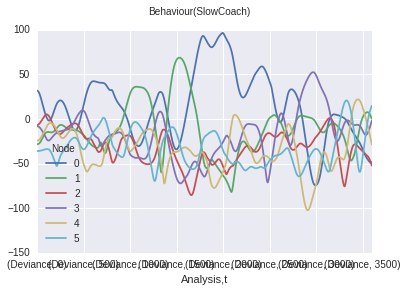

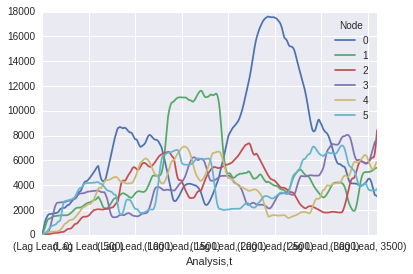

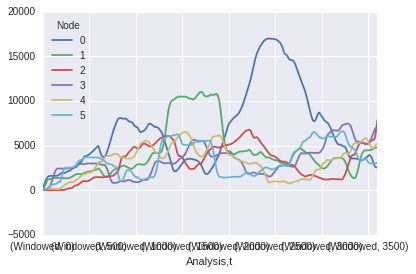

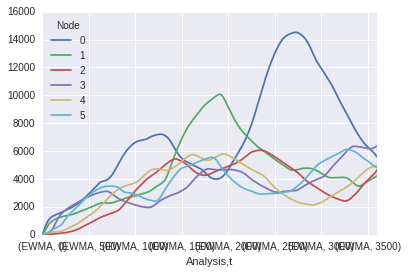

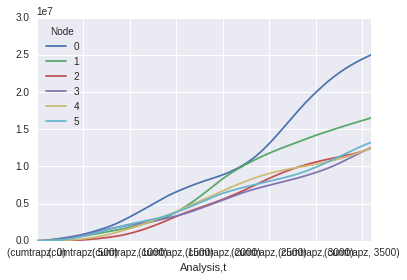

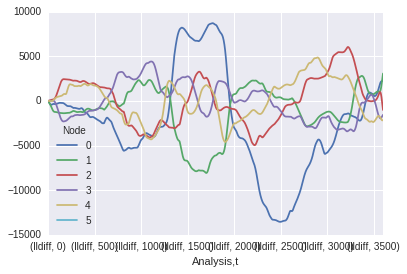

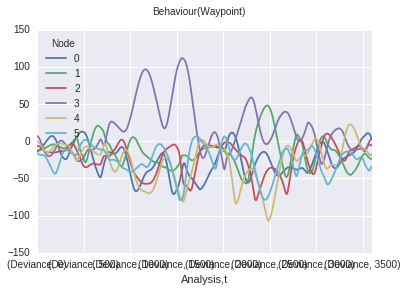

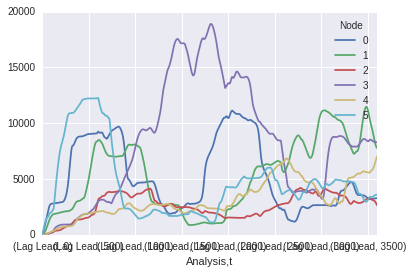

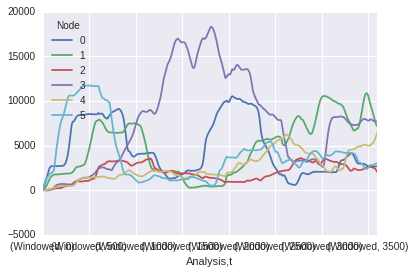

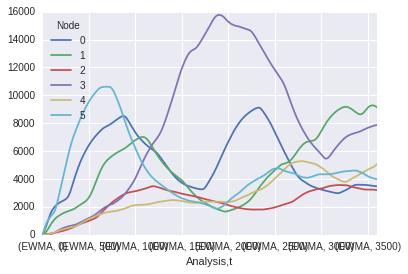

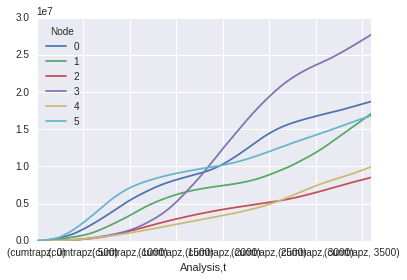

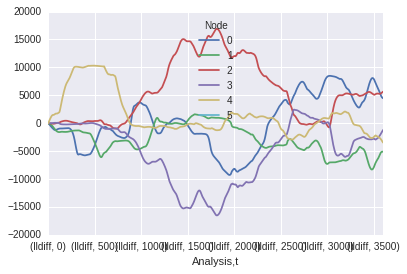

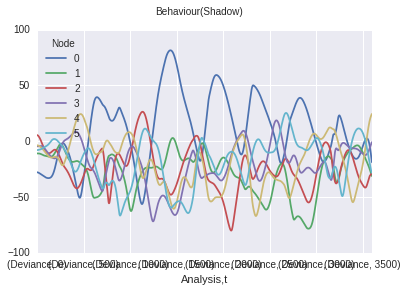

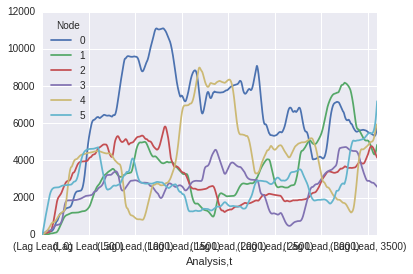

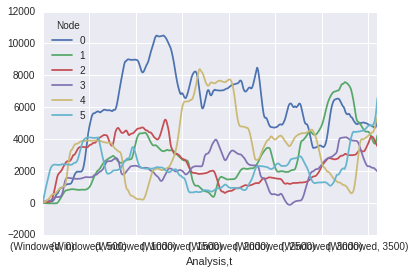

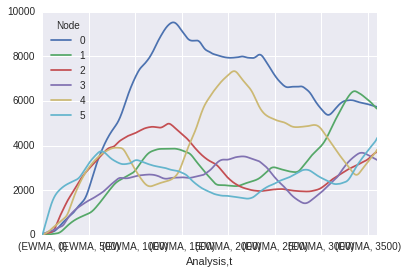

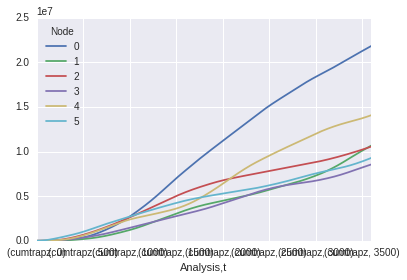

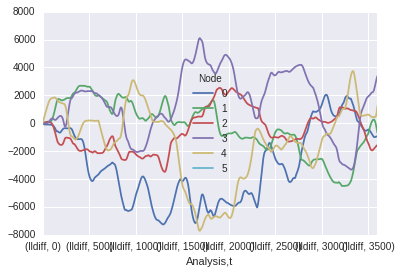

In [20]:
dfs = {}
for t,s in exp.scenarios.items():
    stats = [d.package_statistics() for d in s.datarun]
    df = my_fake_deviance_assessor(s.datarun[0], s.title) # only plays with the first run for experimenting
    dfs[s.title] = df.copy()

stat = stats[0]

In [21]:
df = pd.concat(dfs)
index = list(df.index.names)
index[0]='Behaviour'
df.set_index(df.index.rename(index), inplace=True)

Analysis
Deviance    Axes(0.125,0.125;0.775x0.775)
EWMA        Axes(0.125,0.125;0.775x0.775)
Lag Lead    Axes(0.125,0.125;0.775x0.775)
Windowed    Axes(0.125,0.125;0.775x0.775)
cumtrapz    Axes(0.125,0.125;0.775x0.775)
lldiff      Axes(0.125,0.125;0.775x0.775)
dtype: object

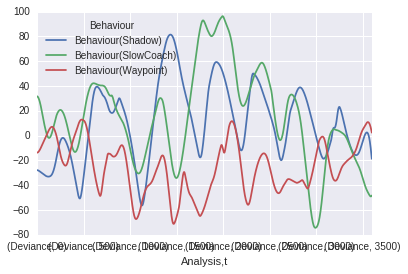

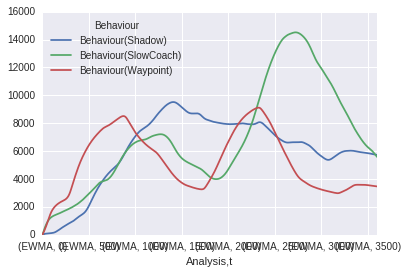

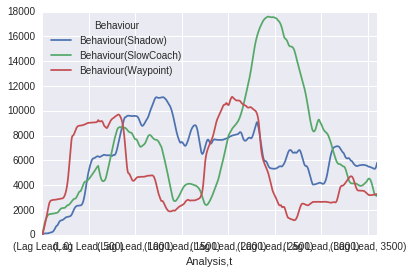

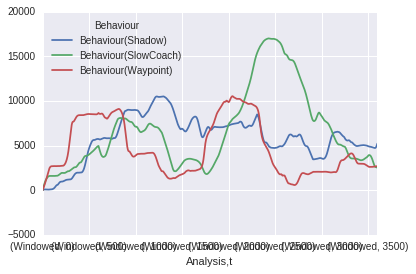

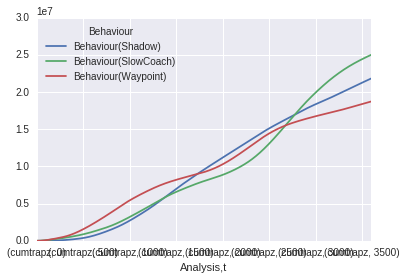

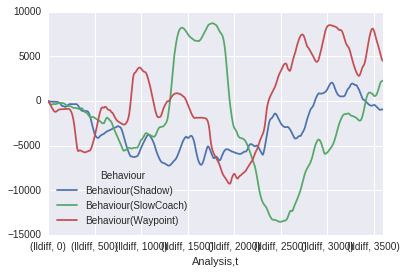

In [22]:
df.unstack('Behaviour')[0].groupby(level='Analysis').plot()

In [25]:
df.head()

Node                                  0          1         2         3  \
Behaviour         Analysis t                                             
Behaviour(Shadow) Deviance 0 -27.847469 -10.952376  5.467802 -4.627058   
                           1 -27.850618 -10.952706  5.460954 -4.626129   
                           2 -27.856910 -10.953364  5.447325 -4.624287   
                           3 -27.866289 -10.954351  5.426919 -4.621542   
                           4 -27.878672 -10.955668  5.399742 -4.617915   

Node                                 4         5  
Behaviour         Analysis t                      
Behaviour(Shadow) Deviance 0 -3.657140 -7.967108  
                           1 -3.659470 -7.966012  
                           2 -3.664153 -7.963801  
                           3 -3.671195 -7.960458  
                           4 -3.680601 -7.955960

In [29]:
df.to_hdf('df.h5','df')

In [33]:
df = pd.get_store('df.h5')['df']

In [34]:
df

Node                                         0            1            2  \
Behaviour           Analysis t                                             
Behaviour(Shadow)   Deviance 0      -27.847469   -10.952376     5.467802   
                             1      -27.850618   -10.952706     5.460954   
                             2      -27.856910   -10.953364     5.447325   
                             3      -27.866289   -10.954351     5.426919   
                             4      -27.878672   -10.955668     5.399742   
                             5      -27.893951   -10.957317     5.365803   
                             6      -27.911992   -10.959300     5.325113   
                             7      -27.932637   -10.961619     5.277687   
                             8      -27.955709   -10.964277     5.223539   
                             9      -27.981011   -10.967277     5.162688   
                             10     -28.008327   -10.970622     5.095154   
                             11     -28.037428   -10.974315     5.020961   
                             12     -28.068075   -10.978359     4.940134   
                             13     -28.099997   -10.982826     4.852748   
                             14     -28.132940   -10.987719     4.758834   
                             15     -28.169005   -10.992309     4.659660   
                             16     -28.208050   -10.996595     4.555266   
                             17     -28.249934   -11.000580     4.445694   
                             18     -28.294519   -11.004265     4.330986   
                             19     -28.340461   -11.009447     4.212400   
                             20     -28.387632   -11.016106     4.089980   
                             21     -28.435906   -11.024225     3.963772   
                             22     -28.485166   -11.033781     3.833824   
                             23     -28.535297   -11.044755     3.700186   
                             24     -28.586190   -11.057124     3.562909   
                             25     -28.637745   -11.070867     3.422045   
                             26     -28.689866   -11.085962     3.277648   
                             27     -28.742463   -11.102386     3.129774   
                             28     -28.795775   -11.120168     2.978180   
                             29     -28.849734   -11.139284     2.822924   
...                                        ...          ...          ...   
Behaviour(Waypoint) lldiff   3570  5227.742637 -5437.543280  5274.444636   
                             3571  5183.835017 -5404.031441  5281.173388   
                             3572  5140.894713 -5372.201751  5288.878790   
                             3573  5099.058376 -5342.076791  5297.555452   
                             3574  5058.365321 -5313.673965  5307.195828   
                             3575  5018.955074 -5287.307390  5317.984249   
                             3576  4980.849447 -5262.902217  5329.821774   
                             3577  4944.068441 -5240.348101  5342.243271   
                             3578  4908.519077 -5219.321139  5354.727980   
                             3579  4874.306409 -5199.885814  5367.258676   
                             3580  4841.445398 -5182.035734  5379.834034   
                             3581  4809.949101 -5165.763845  5392.455540   
                             3582  4779.828595 -5151.062588  5405.127724   
                             3583  4751.092973 -5137.924115  5417.858374   
                             3584  4723.749421 -5126.340546  5430.658721   
                             3585  4697.803446 -5116.304503  5443.543693   
                             3586  4673.259091 -5107.809428  5456.532048   
                             3587  4650.119260 -5100.849778  5469.646358   
                             3588  4628.386072 -5095.421396  5482.913096   
                             3589  4608.061203 -